<a href="https://colab.research.google.com/github/thanhtruong1712/DAMH_KHDLUD/blob/main/Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"**

Nhóm 7:
1. 1712770 - Trương Thị Lệ Thanh - thanhtruong1712
2. 1712771 - Bùi Thái Tấn Thành - thanhtan0501
3. 1712778 - Thống A Thảo - thaothong21

Link thùng chứa Github của nhóm: [https://github.com/thanhtruong1712/DAMH_KHDLUD]

## **Mô tả bài toán**

### Giới thiệu bài toán

* **Tên cuộc thi**: [University of Liverpool - Ion Switching](https://www.kaggle.com/c/liverpool-ion-switching)
* **Mô tả**: 
  - Cuộc thi được diễn ra vào 25/2/2020 và kết thúc vào 26/5/2020 với tổng giải thưởng $25.000 với sự hợp tác của Đại học Liverpool. Trong cuộc thi này, chúng ta được cung cấp các tín hiệu điện tương ứng với dữ liệu kênh ion, và mục tiêu là tạo ra một thuật toán có thể tự động xác định số lượng kênh được mở tại mỗi thời điểm.
  - Kênh ion là các màng protein tạo lỗ có ở động vật và thực vật cho phép các ion đi qua lỗ kênh. Chúng mã hóa khả năng học tập và trí nhớ giúp chống lại nguy cơ nhiễm trùng và kích thích co cơ. Các kênh ion này có thể được ghi lại thông qua kỹ thuật kẹp dính mảnh màng(patch clamp) và được phân tích để suy ra một số đặc tính của bệnh 
* **Input**: Tập dữ liệu tín hiệu điện sinh lý
* **Output**: Dự đoán số lượng kênh ion được mở tại mỗi thời điểm.
* **Độ đo**: Ta có tập train gồm 5 triệu dòng, trong khi tập test gồm 2 triệu dòng. Mục tiêu của cuộc thi này là tối ưu hóa điểm số F1 trên 2 triệu dòng đó. Điểm F1 được định nghĩa là trung bình điều hòa (harmonic mean) giữa precision và recall.
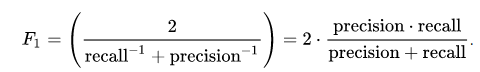

trong đó:
  - Precision được định nghĩa là tỉ lệ số điểm true positive trong số những điểm được phân loại là positive (TP + FP).
  - Recall được định nghĩa là tỉ lệ số điểm true positive trong số những điểm thực sự là positive (TP + FN).
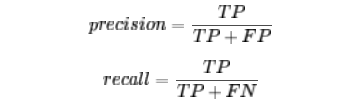



### Mô tả dữ liệu:
  - Dữ liệu được cung cấp khá đơn giản, chỉ chứa 3 cột
    - times: mốc thời gian được ghi lại
    - signal: giá trị tín hiệu điện(ampere) cho mỗi mốc thời gian, các giá trị này được đo ở tần số lấy mẫu là 10 kHz
    - open_channels: số kênh mở tương ứng tại mốc thời gian đó(chỉ được cung cấp cho tập train)
  - Files:
* **train.csv**
* **test.csv**
* **sample_submission.csv**
<br>

## **Giải quyết bài toán**

### 1. Ý tưởng: 
* Trong đồ án này, nhóm tìm hiểu và cài đặt lại phương pháp đứng thứ [3](https://github.com/GillesVandewiele/Liverpool-Ion-Switching) trên private leaderboard cho bài toán University of Liverpool - Ion Switching.
* Tóm tắt các bước thực hiện:
  - Tiền xử lý dữ liệu: loại bỏ nhiễu, biến đổi tuyến tính,...
  - Sử dụng mô hình Markov ẩn
  - Mở rộng mô hình Markov ẩn
  - Hậu xử lý dữ liệu

### 2. Cài đặt





#### 2.1. Căn chỉnh các kênh và tín hiệu bằng hồi quy tuyến tính

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

In [ ]:
train12 = pd.read_csv('./data/train.csv')
test12 = pd.read_csv('./data/test.csv')

##### Khám phá dữ liệu

Đầu tiên chúng ta xem xét các dữ liệu ở tập train và tập test.

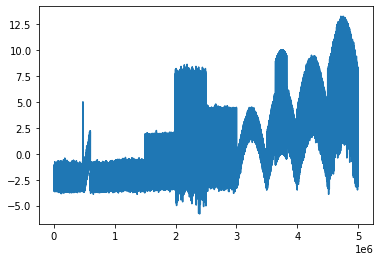

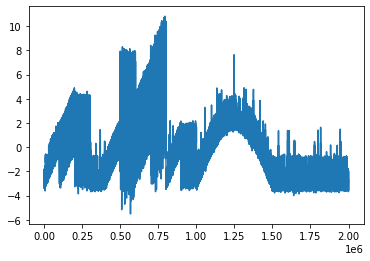

In [ ]:
plt.plot(train12['signal'], label='train signal')
plt.show()
plt.plot(test12['signal'], label='test signal')
plt.show()

Bằng cách kiểm tra các kênh mở trong tập huấn luyện nhiều hơn, chúng ta có thể tìm thấy năm nhóm khác nhau trong tập huấn luyện:
- Một nhóm open_channel bằng 0 hoặc 1. Với nhiều kênh 0 và một vài kênh 1 (category 1).
-Một nhóm open_channel bằng 0 hoặc 1. Với nhiều kênh 1, một vài kênh 0 *category 2)
- Một nhóm open_channel bằng 0,1,2,3. (category 3)
- Một nhóm open_channel bằng 0,1,2,3,4,5. (category 4)
- Một nhóm open_channel bằng 0,1,2,3,4,5,6,7,8,9,10. (category 5)
- Và có thêm một nhóm trong rất giống category 1, nhưng có vài điểm đặc biệt (category 6).

##### Căn chỉnh kênh và tín hiệu


Chúng ta sử dụng hàm hồi quy tuyến tính 1 chiều để điều chỉnh tín hiệu với công thức hồi quy như sau:<br>
$$ \hat x = o + sx $$
- Với o là phần bù
- s là độ dốc của linear regression.

In [ ]:
train = pd.read_csv('./data/train_clean.csv')
test = pd.read_csv('./data/test_clean.csv')

In [ ]:
# Bắt đầu với các batches (* 100_000)
BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])

# The data categories of our batches (5 of them have been identified in Chris Deotte 
# "One Feature Model notebook"). But we have noticed a 6th type in the test data.
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])

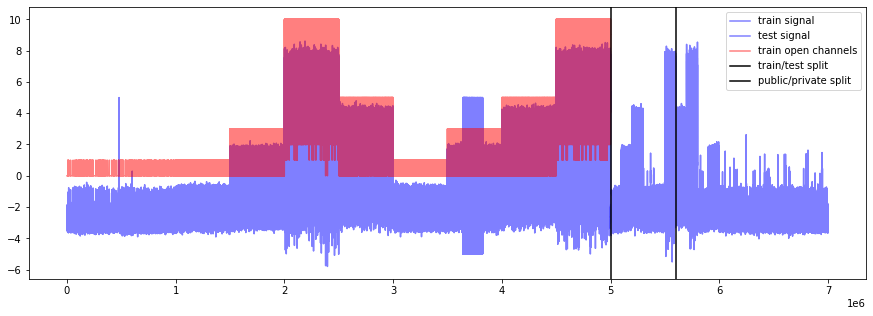

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [ ]:
for c in range(1, 6):
    # Lấy dữ liệu đào tạo tướng ứng với các categories
    ix = np.where(CATEGORIES[:-11] == c)[0]
    starts = BATCHES[ix]
    ends = BATCHES[ix + 1]
    X = []
    y = []
    for start, end in zip(starts, ends):
        subsignal = train['signal'].values[start*100_000:end*100_000]
        subtarget = train['open_channels'].values[start*100_000:end*100_000]
        
        # Bỏ qua phần bất thường giữa 3.6M - 3.9M
        if start == 35:
            subsignal = list(subsignal[:100_000]) + list(subsignal[-100_000:])
            subtarget = list(subtarget[:100_000]) + list(subtarget[-100_000:])
        
        X.extend(subsignal)
        y.extend(subtarget)
    X = np.array(X)
    y = np.array(y)
    
    #Tạo dataframe với các dữ liệu của chúng ta, 
    #thay vì nhóm theo kênh mở và lấy theo giá trị trung bình
    df = pd.DataFrame(np.hstack((X.reshape(-1, 1),
                                 y.reshape(-1, 1))),
                      columns=['X', 'y'])
    means = df.groupby('y')[['X']].mean()
    X = means['X'].values
    y = means.index.values
    
    # Huấn luyện với mô hình Linear regression
    lr = LinearRegression()
    lr.fit(X.reshape(-1, 1), y)
    print(c, lr.intercept_, lr.coef_)

1 2.204145338888842 [0.80862586]
2 2.2169991958143207 [0.81071421]
3 2.2229470830947 [0.81240389]
4 2.22104339998811 [0.80972639]
5 4.451422627735052 [0.80219267]


In [ ]:
# As we tuned the entire pipeline during the competition, we also adjusted these
# values a little bit and checked the impact on our training F1 score. Below
# are our final values:
OFFSETS = [2.180783, 2.221318, 2.221318, 2.221318, 4.4288541, 2.221318]
SLOPE = 0.8107

signal = np.concatenate((train['signal'].values, test['signal'].values))
for i, (start, end) in enumerate(zip(BATCHES[:-1], BATCHES[1:])):
    c = CATEGORIES[i] - 1
    signal[start*100_000:end*100_000] = OFFSETS[c] + SLOPE * signal[start*100_000:end*100_000]

train['signal'] = signal[:5_000_000]
test['signal'] = signal[5_000_000:]

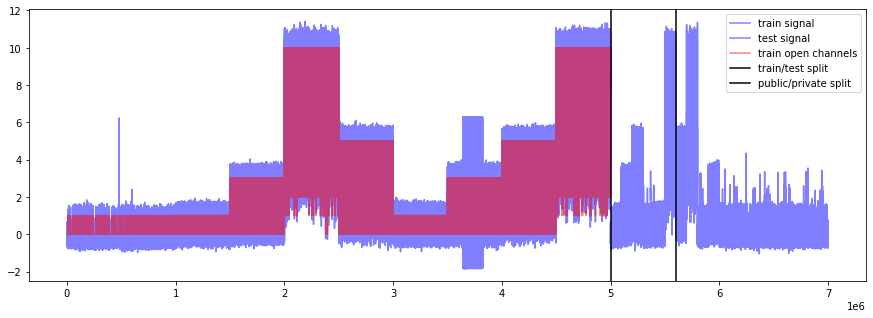

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [ ]:
# Let's check what our F1 score would be if we just round our signal values
#Kiểm tra với độ đo F1_score nếu chúng ta chỉ làm tròn giá trị tín hiệu.
good_ids = list(range(0, 3_600_000)) + list(range(3_900_000, 5_000_000))
f1_score(train['open_channels'].values[good_ids], 
         np.clip(np.round(train['signal'].values[good_ids]).astype(int), 0, 10), 
         average='macro')

0.9211271639823664

In [ ]:
train.to_csv('./data/train_1.csv', index=False)
test.to_csv('./data/test_1.csv', index=False)

#### 2.2. Khử nhiễu 50Hz

Ngay sau khi bắt đầu cuộc thi, tác giả phát hiện ra rằng ban tổ chức cuộc thi đã đưa vào dữ liệu nhiễu nhân tạo. Sau đó tác giả tiến hành khử nhiễu bằng cách sử dụng một hàm sin với tần số rất thấp (với chu kỳ là 1.000.000 giá trị)

Chúng ta có thể kiểm tra tiếng ồn này bằng cách tính toán đơn giản như sau:


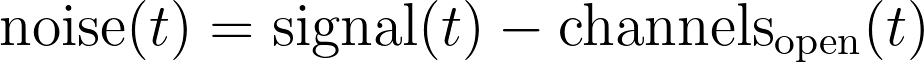

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import scipy.optimize as opt
from sklearn.metrics import f1_score
from collections import defaultdict

In [ ]:
train = pd.read_csv('./data/train_1.csv')
test = pd.read_csv('./data/test_1.csv')
predictions = pd.read_csv('./data/Ys.csv', index_col=None, skiprows=1, header=None).values.flatten()

In [ ]:
signal = np.concatenate((train['signal'].values, test['signal'].values))
noise = signal - (0.2 * predictions + 0.8 * np.round(predictions))
offset = np.median(noise)
noise = noise - offset
noise = np.clip(noise, -0.8, 0.8)
train['signal'] = signal[:5_000_000]
test['signal'] = signal[5_000_000:]

Dưới đây là biểu đồ của 10000 giá trị nhiễu đầu tiên trong tập huấn luyện:

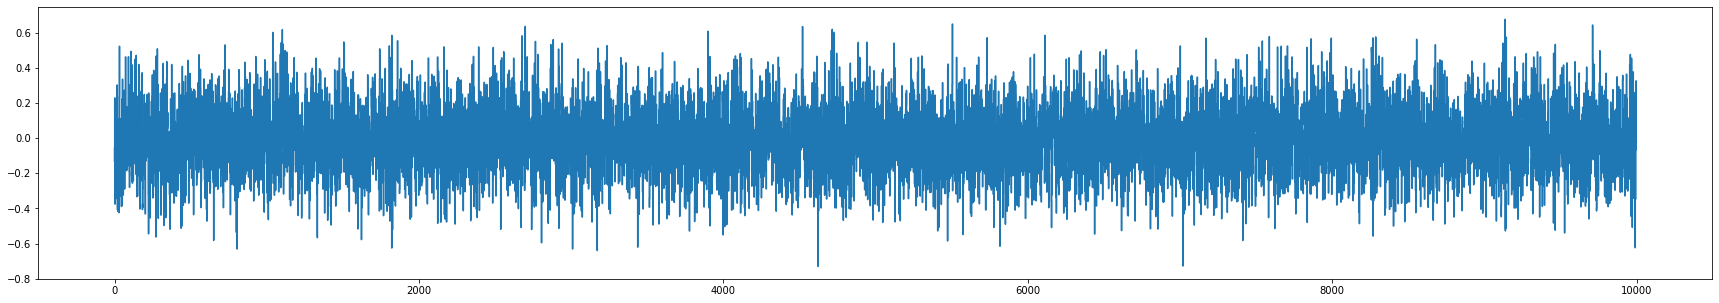

In [ ]:
plt.figure(figsize=(30, 5))
plt.plot(noise[:10000],drawstyle= 'steps')
plt.show()

Chúng ta có thể thấy rõ một sóng có đỉnh trung bình cứ sau 200 giá trị. Tín hiệu tuần hoàn, được đo ở tần số lấy mẫu 10 kHz, với chu kỳ khoảng 200, tương ứng với tần số 50 Hz. Nó chỉ ra rằng nguồn điện xoay chiều ở Anh có tần số 50 Hz! Để loại bỏ,
chúng ta sẽ điều chỉnh hàm sin trên mỗi lô 100000 giá trị nhiễu. Mặc dù các kỹ thuật xử lý tín hiệu, chẳng hạn như bộ lọc dải thông và dải băng tần cũng có thể thực hiện điều này, nhưng bằng cách sử dụng một hàm sin đơn giản lại kết quả tốt hơn. Nó cũng chỉ ra rằng có nhiều thành phần trong hàm sin (tức là nhiều sóng sin với các biên độ, pha và tần số khác nhau) hoạt động tốt nhất.

In [ ]:
BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])

In [ ]:
CAT5_SIN_PARAMS = [
# 1st train batch (0-100K)
[0.057, 0.0313961337824152, -1.9582981618981699, 
 0.052000000000000005, 0.0313373879661514, -0.894787657310209, 
 0.00312544415186912, 0.71604979030357, 1.4740988377606499, 
 0.0, 0.764755919779924, 0.0829734133838624],
# 1st train batch (100K-200K)
[0.057, 0.0313095771558318, -0.35820841715589197, 
 0.0569999999999976, 0.031379394855977204, -0.230748302134919,
 0.00253486686822344, 0.715851225706187, -0.026387038081517898, 
 0.0, 0.7465297968654719, -0.0894642790306936],
# 1st train batch (200K-300K)
[0.05263655157016801, 0.0314659272351229, 0.721245080052644, 
 0.052000000000000005, 0.0313174115779501, -1.37524249139897, 
 0.00226771045170094, 0.715873941177297, 0.56031287795554, 
 0.0019583453631626, 0.7286561468259489, -1.02618438535636],
# 1st train batch (300K-400K)
[0.057, 0.0313245064928946, 2.06319152201257, 
 0.052000000003234, 0.031446893905081, -1.6084985645729901, 
 0.00204345494144802, 0.71565222942307, -1.89474551042615, 
 0.0026604410809482797, 0.7284881442918499, 0.7151709270600919],
# 1st train batch (400K-500K)
[0.056679791179581704, 0.031382822206142295, -3.5348478221412, 
0.052000000000000005, 0.0313178273242294, -1.00966029805514, 
 0.0016164838108070302, 0.716048844816851, -2.59390758029503e-05, 
 0.00210240831407528, 0.727720466174145, 0.706750747651938],
# 2nd train batch (0-100K)
[0.052000000000000005, 0.0313670674841525, -1.37434901558769, 
 0.0520000000021022, 0.0313783360445586, 2.92821291855846, 
 0.00247837389454667, 0.7158583949172861, -0.40179295728015496, 
 0.00437980418941088, 0.728349991781816, 3.73281587410011],
# 2nd train batch (100K-200K)
[0.0520000000000012, 0.0313514090723553, -0.7592491943882651, 
 0.052000000000000005, 0.031413273914979195, 0.935896221804064, 
 0.00206902568326639, 0.715918789583516, -1.35448757805627, 
 0.00166972502016302, 0.728623972795409, -1.4221758956342],
# 2nd train batch (200K-300K)
[0.052000000000287205, 0.0313326971169099, 1.4075870088394502, 
 0.0554068634006138, 0.0313842512482485, 0.048745427259011403, 
 0.0025172803889046804, 0.7155805029559871, 0.5406817908985491, 
 0.00161604404966698, 0.729016882437157, 1.8120270717328],
# 2nd train batch (300K-400K)
[0.052000000000000005, 0.031409876692340605, -0.7456245686622709, 
 0.0520000000001529, 0.0313705465395396, 0.936863731408621, 
 0.00277763601864694, 0.71570598138205, -1.44532928551161, 
 0.00211063918551229, 0.728488636873564, -1.68280443918254],
# 2nd train batch (400K-500K)
[0.057, 0.0313882617049079, 1.03970925443823, 
 0.0569999997793795, 0.031387205017098, -4.4219546144679995, 
 0.0033378429937860198, 0.7159949659289311, -0.592157376889125, 
 0.0, 0.7701378258839879, -0.578583201201017],
# Public LB Part
[0.052000000000000005, 0.031340030736758, 2.03496434423533, 
 0.057, 0.0313644869979618, 5.994735891834329, 
 0.0030110230573384, 0.71556629357372, 3.95735883922847, 
 0.0, 0.718902128677972, 0.0990162017704937],
# Private LB Part
[0.052000000000000005, 0.0313962479935369, 2.25668278709478, 
 0.052000000000000005, 0.0313859582890873, -4.05125563031034, 
 0.00235983507549681, 0.715410020428299, -0.0953467752653618, 
 0.0, 0.7255387616378449, -1.89409831367182]
]

In [ ]:
def sin_1(t, A, w, p):
    return A * np.sin(w*t + p)

def sin_4(t, A1, w1, p1, A2, w2, p2, A3, w3, p3, A4, w4, p4):
    return A1 * np.sin(w1*t + p1) + A2 * np.sin(w2*t + p2) + A3 * np.sin(w3*t + p3) + A4 * np.sin(w4*t + p4)

def get_guess(tt, yy, components=1):
    """Initialize amplitudes at 0.053, phases at 0 and get the frequencies 
    corresponding to the highest strengths."""
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    freqs = ff[np.argsort(Fyy[1:])[::-1] + 1]
    result = set()
    for f in freqs:
        result.add(abs(f))
        if len(result) == components:
            break
    guess = []
    for f in result:
        guess += [0.053, min(0.0315, max(0.031, 2*np.pi*f)), 0]
    
    return guess

def fit_sin1(tt, yy):
    '''Fit sine wave to the input time sequence'''
    # Taken from: https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    guess = np.array(get_guess(tt, yy))
    popt, pcov = opt.curve_fit(sin_1, tt, yy, p0=guess, maxfev=10000)
    return {"parameters": popt, "fitfunc": lambda t: sin_1(t, *popt)}

def fit_sin(signal, channels, c, b):
    # This noise calculation worked better than a simple signal - channels
    noise = signal - (0.2 * channels + 0.8 * np.round(channels))
    offset = np.median(noise)
    noise = noise - offset
    noise = np.clip(noise, -0.8, 0.8)
    if c != 5:
        results = fit_sin1(np.arange(len(noise)), noise)
    else:
        results = {'fitfunc': lambda t: sin_4(t, *CAT5_SIN_PARAMS[b])}
    plt.figure()
    plt.plot(noise[:10000])
    plt.plot(results['fitfunc'](np.arange(len(signal)))[:10000])
    plt.show()
        
    return signal - results['fitfunc'](np.arange(len(signal))) - offset

def remove_power_line(signal, predictions):
    """Iterate over segments of 100K and remove the power line interference"""
    count_per_cat = defaultdict(int)
    for i, (start, end) in enumerate(zip(BATCHES[:-1], BATCHES[1:])):
        c = CATEGORIES[i]
        for k in range(end - start):
            sub_start = (start + k) * 100_000
            sub_end = (start + k + 1) * 100_000
            signal[sub_start:sub_end] = fit_sin(signal[sub_start:sub_end], 
                                                predictions[sub_start:sub_end], 
                                                c, count_per_cat[c])
            count_per_cat[c] += 1
    return signal

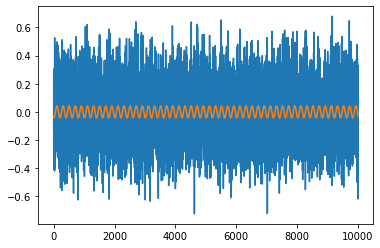

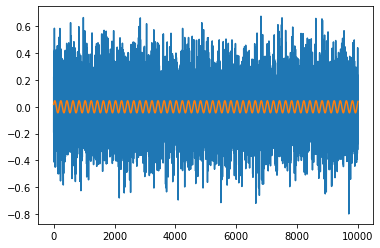

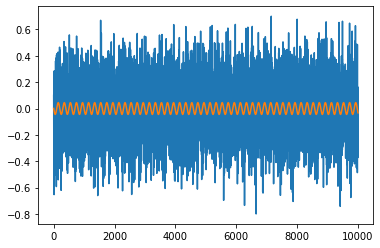

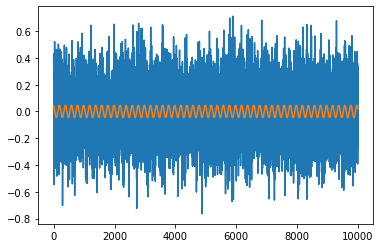

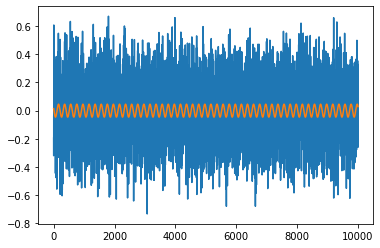

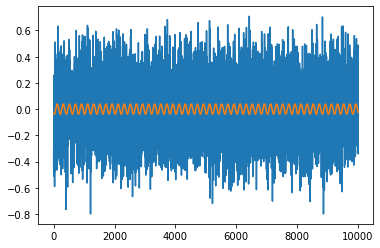

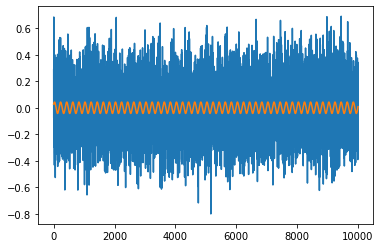

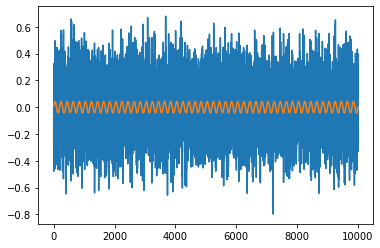

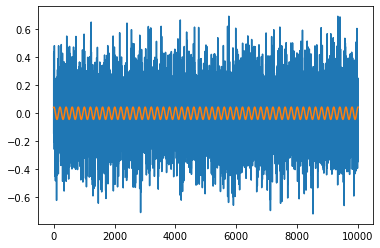

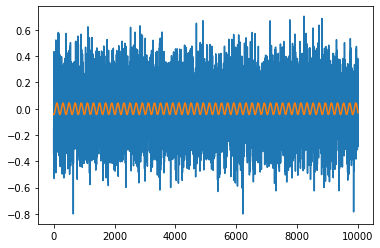

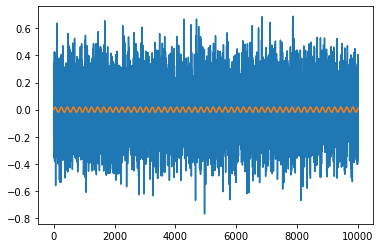

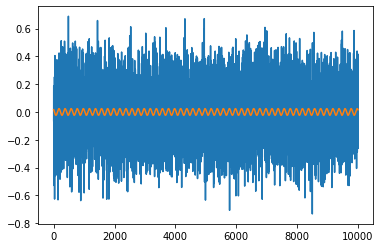

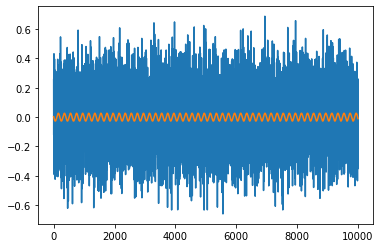

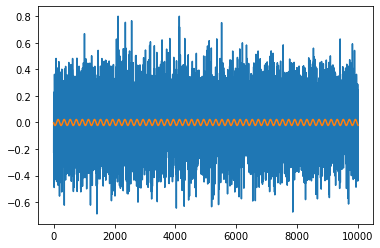

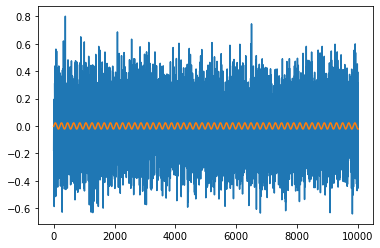

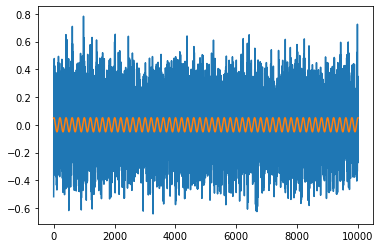

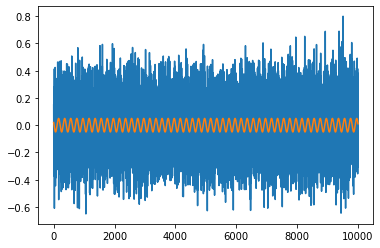

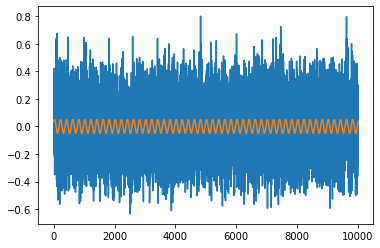

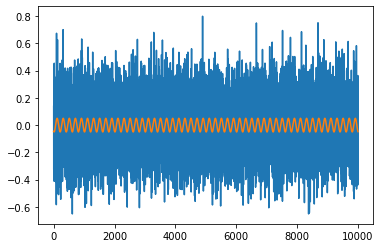

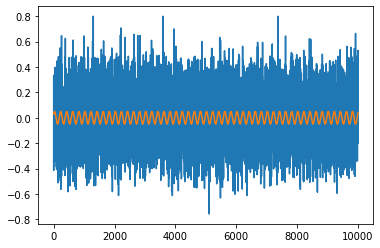

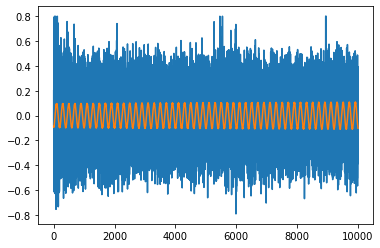

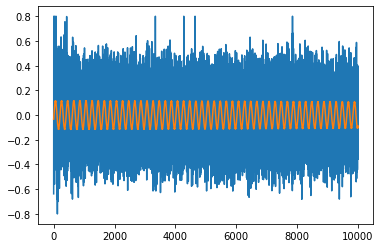

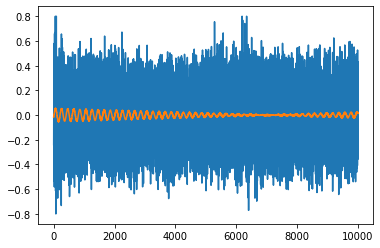

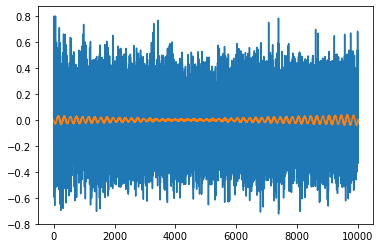

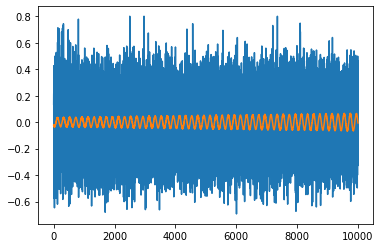

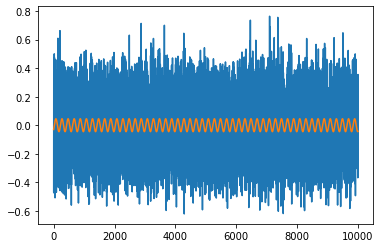

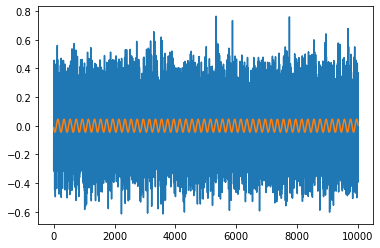

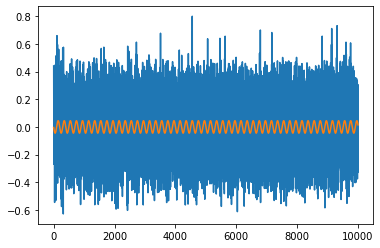

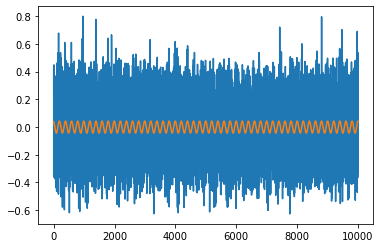

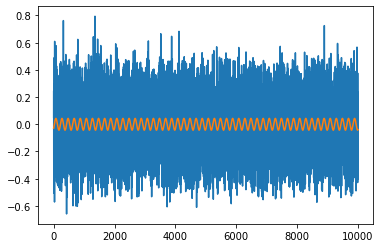

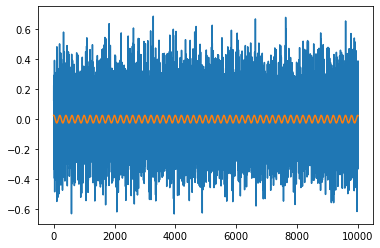

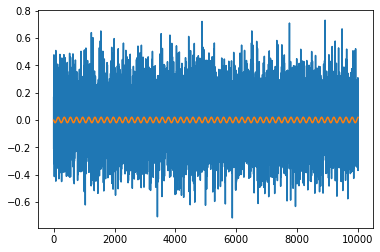

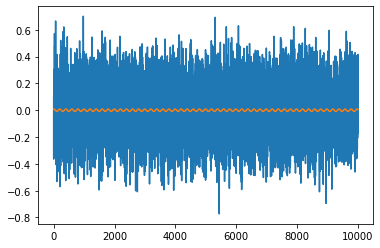

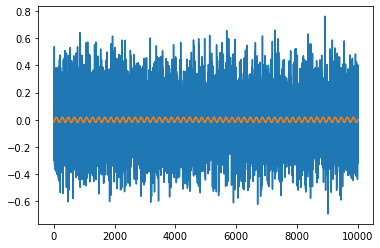

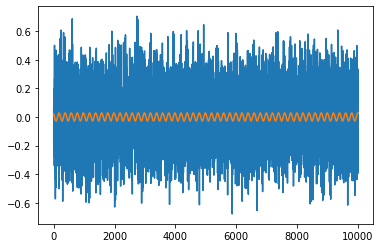

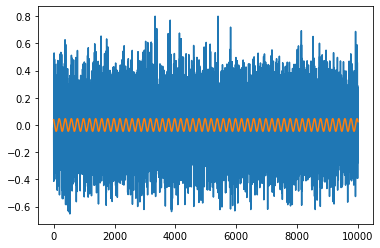

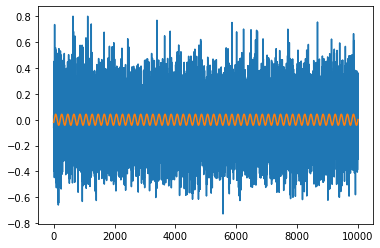

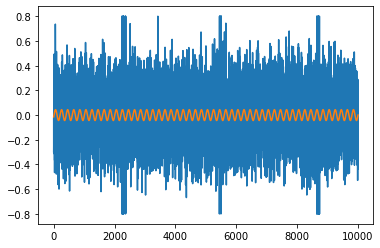

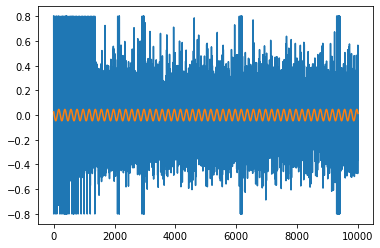

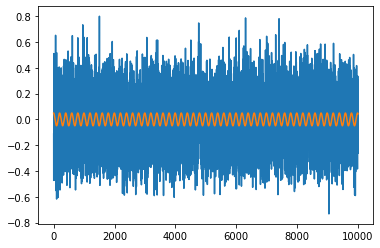

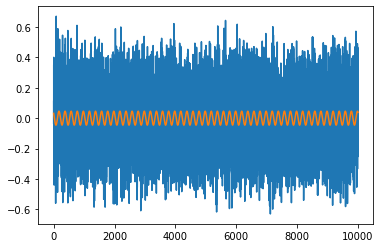

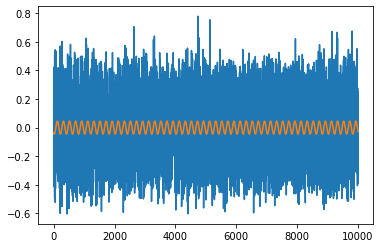

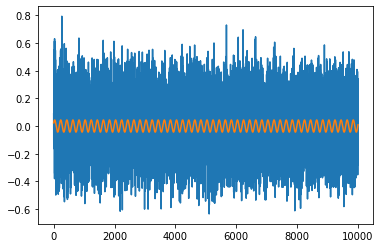

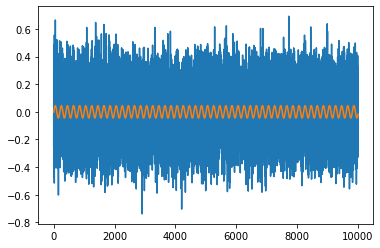

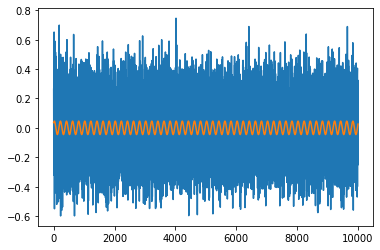

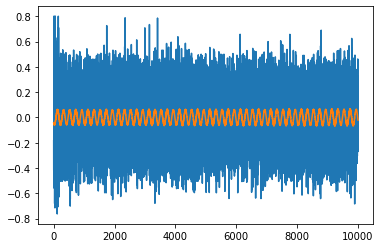

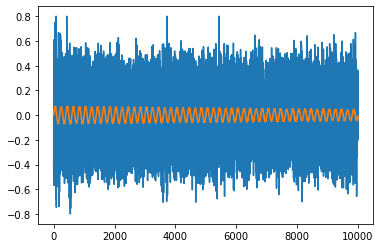

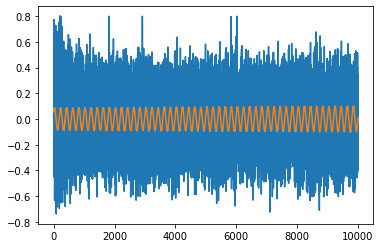

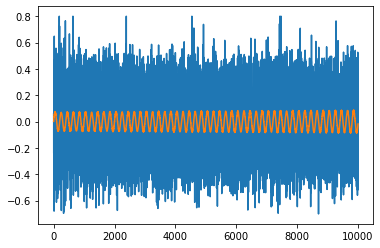

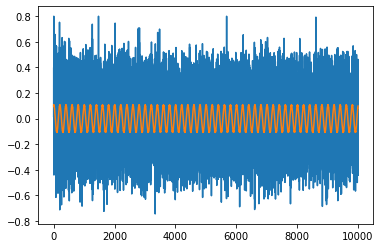

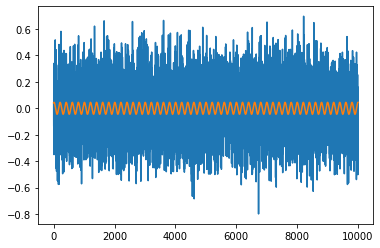

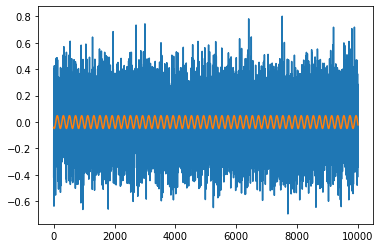

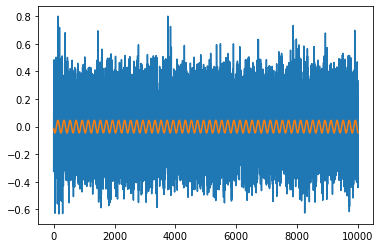

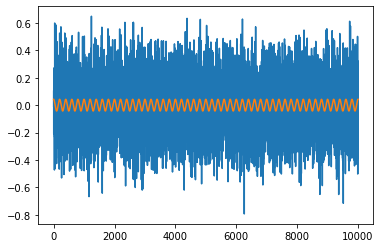

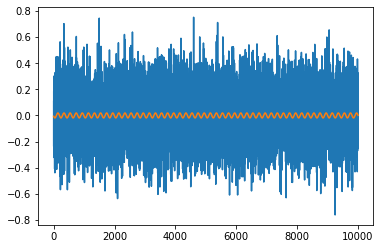

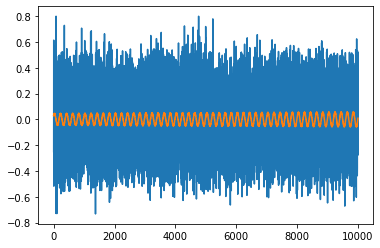

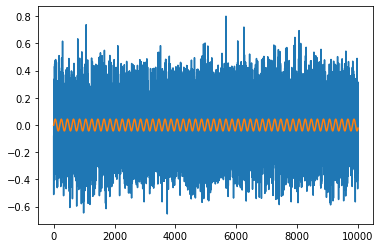

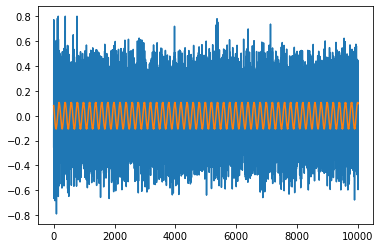

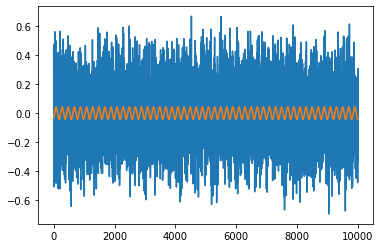

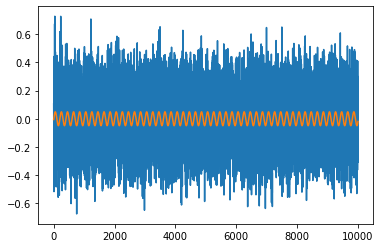

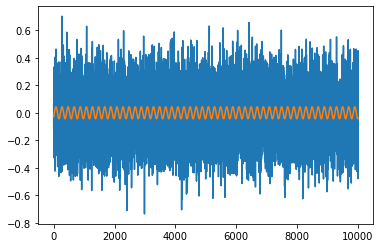

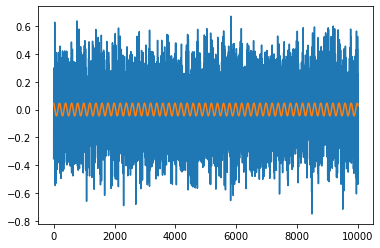

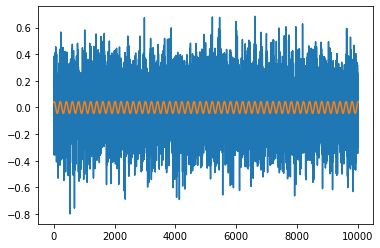

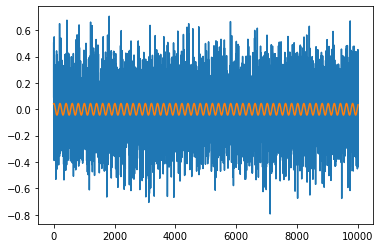

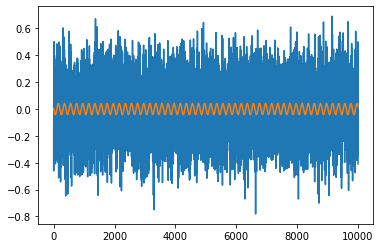

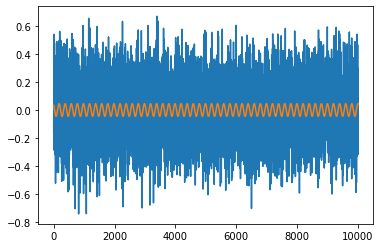

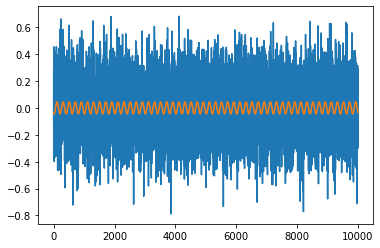

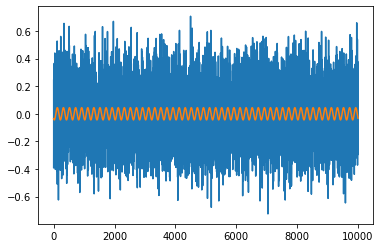

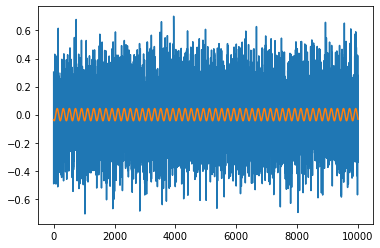

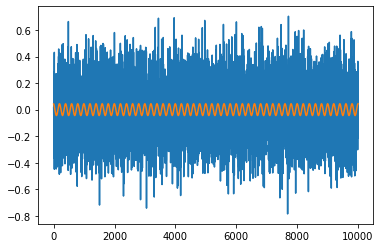

In [ ]:
signal = np.concatenate((train['signal'].values, test['signal'].values))
remove_power_line(signal, predictions)
train['signal'] = signal[:5_000_000]
test['signal'] = signal[5_000_000:]

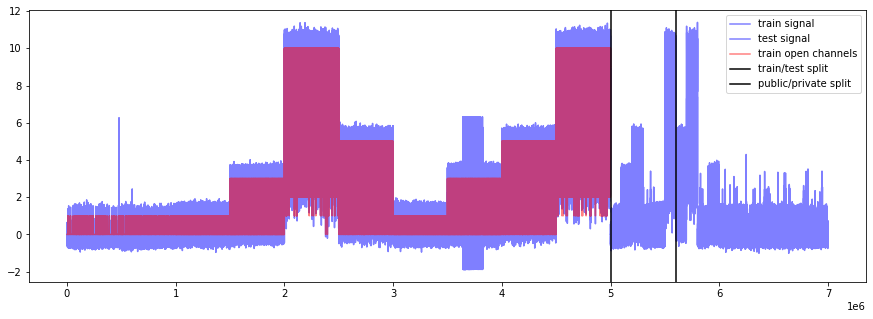

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [ ]:
# Did this improve our simple baseline as the noise is reduced?
good_ids = list(range(0, 3_600_000)) + list(range(3_900_000, 5_000_000))
f1_score(train['open_channels'].values[good_ids], 
         np.clip(np.round(train['signal'].values[good_ids]).astype(int), 0, 10), 
         average='macro')

0.9250193100885252

In [ ]:
train.to_csv('./data/train_2.csv', index=False)
test.to_csv('./data/test_2.csv', index=False)

#### 2.3. Tiếp cận Naive HMM

Ở bước này, tác giả sẽ điều chỉnh một HMM có số trạng thái ẩn bằng số kênh mở duy nhất trong mỗi lô. Đây là một cách tiếp cận đơn giản mà tác giả sẽ cải thiện sau này, nhưng đã được cải thiện dựa trên đường cơ sở của các giá trị làm tròn của tín hiệu .

Ta có, Mô hình Markov ẩn được xác định bởi các tham số sau:
* Số lượng trạng thái ẩn (=K)
* Xác suất khởi tạo (vectơ có kích thước K)
* Ma trận chuyển tiếp (ma trận K x K)
* Xác suất phát xạ. Mỗi trạng thái ẩn phát ra một giá trị quan sát nhất định. Các phát xạ này có thể có các phân bố khác nhau, chẳng hạn như đa danh cho phát xạ rời rạc và một Gauss cho phát xạ liên tục (chúng ta sẽ sử dụng ở đây, vì tín hiệu điện của chúng ta là liên tục).


Tóm lại, các kênh mở (biến ẩn) tuân theo một quy trình Markov nhất định và chuyển từ giá trị này sang giá trị khác với các xác suất nhất định được xác định bởi ma trận chuyển tiếp. Khi quy trình Markov ở một trạng thái ẩn nó sẽ phát ra một giá trị có thể quan sát được gọi là tín hiệu điện.

In [ ]:
!pip install hmmlearn==0.2.3

In [ ]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import f1_score

In [ ]:
# Sử dụng kết quả từ bước 2
train = pd.read_csv('./data/train_2.csv')
test = pd.read_csv('./data/test_2.csv')

In [ ]:
BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])
CATEGORY = 3

signal = np.concatenate((train['signal'].values, test['signal'].values))

ix = np.where(CATEGORIES == CATEGORY)[0]
starts = BATCHES[ix]
ends = BATCHES[ix + 1]

X = []
y = []
for start, end in zip(starts, ends):
    subsignal = signal[start*100_000:end*100_000]
    if start < 50:
        subchannels = train['open_channels'].values[start*100_000:end*100_000]
    else:
        subchannels = [-1]*((end-start)*100_000)
        
    if start == 35:
        subsignal = list(subsignal[:100000]) + list(subsignal[-100000:])
        subchannels = list(subchannels[:100000]) + list(subchannels[-100000:])
    
    X.extend(subsignal)
    y.extend(subchannels)
    
X = np.array(X)
y = np.array(y)
print(len(X), len(y))

900000 900000


Giả sử mô hình Markov của chúng ta có 4 trạng thái ẩn. Các trạng thái ẩn có số kênh mở lần lượt là 0, 1, 2, 3. Chúng ta có thể ước tính cả ma trận chuyển tiếp và phân bố phát xạ một cách dễ dàng bằng cách xem dữ liệu train, có nghĩa là đếm chuyển đổi từ trạng thái này sang trạng thái khác và xem xét các giá trị tín hiệu tương ứng với một số kênh mở nhất định.

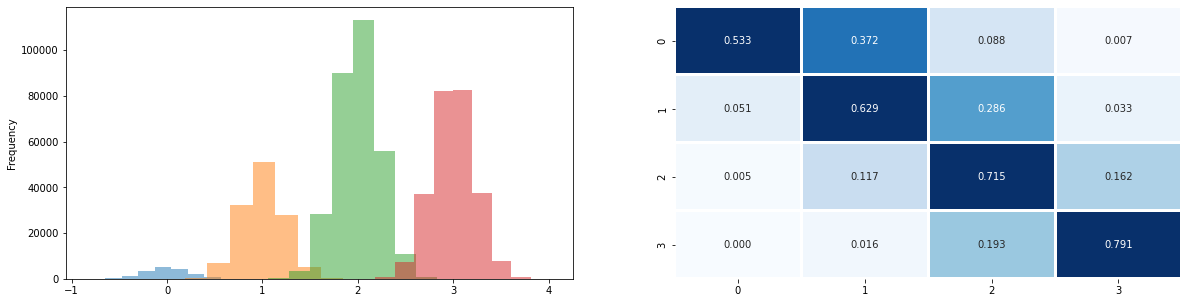

         1     -553582.1423             +nan
         2     -553346.4911        +235.6512
         3     -553334.3024         +12.1887
         4     -553332.9421          +1.3603
         5     -553332.7455          +0.1966
         6     -553332.7132          +0.0323
         7     -553332.7075          +0.0057


In [ ]:
def markov_p_trans(states):
    # https://www.kaggle.com/friedchips/the-viterbi-algorithm-a-complete-solution
    max_state = np.max(states)
    states_next = np.roll(states, -1)
    matrix = []
    for i in range(max_state + 1):
        current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
        if np.sum(current_row) == 0: # nếu 1 trạng thái không xuất hiện trong các trạng thái
            current_row = np.ones(max_state + 1) / (max_state + 1) # ...sử dụng xác suất đồng nhất
        else:
            current_row = current_row / np.sum(current_row) # chuẩn hóa về 1
        matrix.append(current_row)
    return np.array(matrix)

f, ax = plt.subplots(1, 2, figsize=(20, 5))

# Ước lượng ma trận chuyển đổi dựa trên ground truth
Ptran = markov_p_trans(y[y >= 0])
sns.heatmap(
    Ptran,
    annot=True, fmt='.3f', cmap='Blues', cbar=False,
    ax=ax[1], vmin=0, vmax=0.5, linewidths=2);


# Ước lượng trung bình và hiệp phương sai cho mỗi giá trị ground truth duy nhất
means = []
covs = []
for c in sorted(np.unique(y[y >= 0])):
    pd.Series(X[y == c]).plot(kind='hist', ax=ax[0], alpha=0.5)
    means.append(np.mean(X[y == c]))
    covs.append(np.cov(X[y == c]))
    
plt.show()
    
# Xác định HMM
n_classes = len(np.unique(y[y >= 0]))
hmm = GaussianHMM(
    n_components=n_classes,             # Số trạng thái ẩn
    n_iter=50,                          # Tổng số lần lặp
    verbose=True,                       # Hiển thị logs
    algorithm='map',                    # Sử dụng cực đại một posteriori thay cho Viterbi
    params='stmc',                      # Optimize start probs, transmat, means, covs
    random_state=42,
    init_params='s',                    # Khởi tạo thủ công tất cả trừ các xác suất bắt đầu
    covariance_type='full',             # Hiệp phương sai riêng cho mỗi trạng thái ẩn
    tol=0.01                            # Tiêu chí hội tụ
)

# Khởi tạo các tham số của HMM
hmm.n_features = 1
hmm.means_ = np.array(means).reshape(-1 ,1)
hmm.covars_ = np.array(covs).reshape(-1, 1, 1)
hmm.transmat_ = Ptran

# Fit HMM 
_ = hmm.fit(X.reshape(-1, 1), lengths=[100000]*(len(X) // 100000))

Ta thấy, nếu số kênh mở bằng 3, thì giá trị tín hiệu cũng sẽ xung quanh 3. Giá trị tiếp theo sẽ bằng 3 với xác suất 79,1%, 2 với xác suất 19,3%, 1 với xác suất 1,6% hoặc 0 với xác suất 0%. Các thông số này có thể được ước tính bằng cách sử dụng dữ liệu train, hoặc bằng cách áp dụng thuật toán Baum-Welch. Thuật toán này, là một trường hợp đặc biệt của thuật toán Expectation-Maximization - là một thuật toán không được giám sát. Tóm lại, nó sẽ đưa ra các dự đoán dựa trên các tham số ban đầu của nó và sau đó sử dụng các dự đoán này để cập nhật các tham số cho đến khi hội tụ. Sau đó, từ các tham số chúng ta có thể thực hiện suy luận bằng cách áp dụng thuật toán Forward và Backward - trả về ma trận xác suất P, trong đó P[t][k] sẽ là xác suất ở trạng thái ẩn k tại thời điểm t.

In [ ]:
# Đưa ra dự đoán
preds = hmm.predict(X.reshape(-1, 1), lengths=[100000]*(len(X) // 100000))

# Đường cơ sở làm tròn
print(f1_score(y[y >= 0], np.clip(np.round(X[y >= 0]).astype(int), 0, np.max(y)), average='macro'))

# Score của Naive HMM
print(f1_score(y[y >= 0], preds[y >= 0], average='macro'))

0.9737641582485055
0.9840923260389285


## Nhìn lại quá trình làm đồ án

Sau bao ngày vất vả làm đồ án thì bây giờ đã kết thúc. Bây giờ là lúc để ngồi uống coffee và tĩnh tâm nhìn lại quá trình làm.

- Mỗi thành viên: Đã gặp những khó khăn gì? (Hay mọi chuyện đều thuận lợi)
- Mỗi thành viên: Có học được gì hữu ích? (Hay không học được gì)
- Nhóm: Nếu có thêm thời gian thì sẽ làm gì?

Phần này có sao thì bạn nói vậy thôi, chứ không phải là viết
cho có, hoặc tự chế ra để nghe cho hay.

## Tài liệu tham khảo

Để hoàn thành đồ án này, nhóm bạn đã tham khảo những tài liệu nào?
- https://towardsdatascience.com/identifying-the-number-of-open-ion-channels-with-hidden-markov-models-334fab86fc85#cf75